# How to Use Geo Data: Part 1 - Preparing Data
> Insert blurb about where the data is from and how/why we're using it. Data can be found [here](https://ckan.africadatahub.org/dataset/south-africa-high-resolution-population-density-maps-demographic-estimates).

- toc: true 
- badges: false
- comments: false
- categories: [geo data, population density]
- image: images/chart-preview.png

In [1]:
#hide
'''
import pandas as pd
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
from rasterio.plot import show
'''

The csv file is considerably smaller than the tif file, so let's begin with that. The first thing we need to do is convert it from a simple csv to geojson in order to be able to map it.

In [7]:
#hide
'''
data_path = '/mnt/c/Users/heiko/Documents/Work/OCL/ADH/Data_Blog/adh_data_blog/_notebooks/data/zaf_geo_data_blog/'
create_gdf = False
if create_gdf == True:
  df = pd.read_csv('%szaf_women_2020_csv.zip'% data_path)
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
  gdf.to_file('%szaf_women_2020_csv_geo.geojson'% data_path, driver='GeoJSON')
  del df, gdf
'''

The tif file is very big - around 21GB when unzipped. This is too big for most machines to handle in Python, and you would be better off using a decidicated mapping tool like `QGIS`. As such, we should rather look to use the csv file, which is much smaller. However, first we should confirm that the data is the same. To do that, we select only a small part of the tif file and compare it with the same area in the csv file.

In [8]:
'''
with rasterio.open('zip:///%szaf_women_2020_geotiff.zip!/zaf_women_2020.tif'%data_path) as src:  
  n = 500
  data = src.read(1, window=Window(0, 0, n, n))
  print('Band1 has shape', data.shape)
  height = data.shape[0]
  width = data.shape[1]
  cols, rows = np.meshgrid(np.arange(width), np.arange(height))
  xs, ys = rasterio.transform.xy(src.transform, rows, cols)
  lons= np.array(xs)
  lats = np.array(ys)
  print('lons shape', lons.shape)
'''

Band1 has shape (500, 500)
lons shape (500, 500)


Now we have a subset of the tif file, but in order to be able to compare it with the csv file, we need to convert both into geopandas dataframes. To do that, we need to change the shape of the tif file's data.

In [9]:
'''
lons2 = lons.flatten()
lats2 = lats.flatten()
data2 = data.flatten()

data_df = pd.DataFrame({'pop_dens':data2,'latitude':lats2,'longitude':lons2}).dropna()
data_gdf = gpd.GeoDataFrame(data_df.pop_dens, geometry=gpd.points_from_xy(data_df.longitude, data_df.latitude, crs="EPSG:4326"))

lon_min= data_df.longitude.min()
lon_max = data_df.longitude.max()
lat_min= data_df.latitude.min()
lat_max = data_df.latitude.max()
'''

In [11]:
#gdf_box = gpd.read_file('%szaf_women_2020_csv_geo.geojson'%data_path,bbox=(lon_min, lat_min, lon_max, lat_max))

Right, let's take a look at the subset of the tif data. We can also zoom in to see that each point in the tif file is a square pixel.

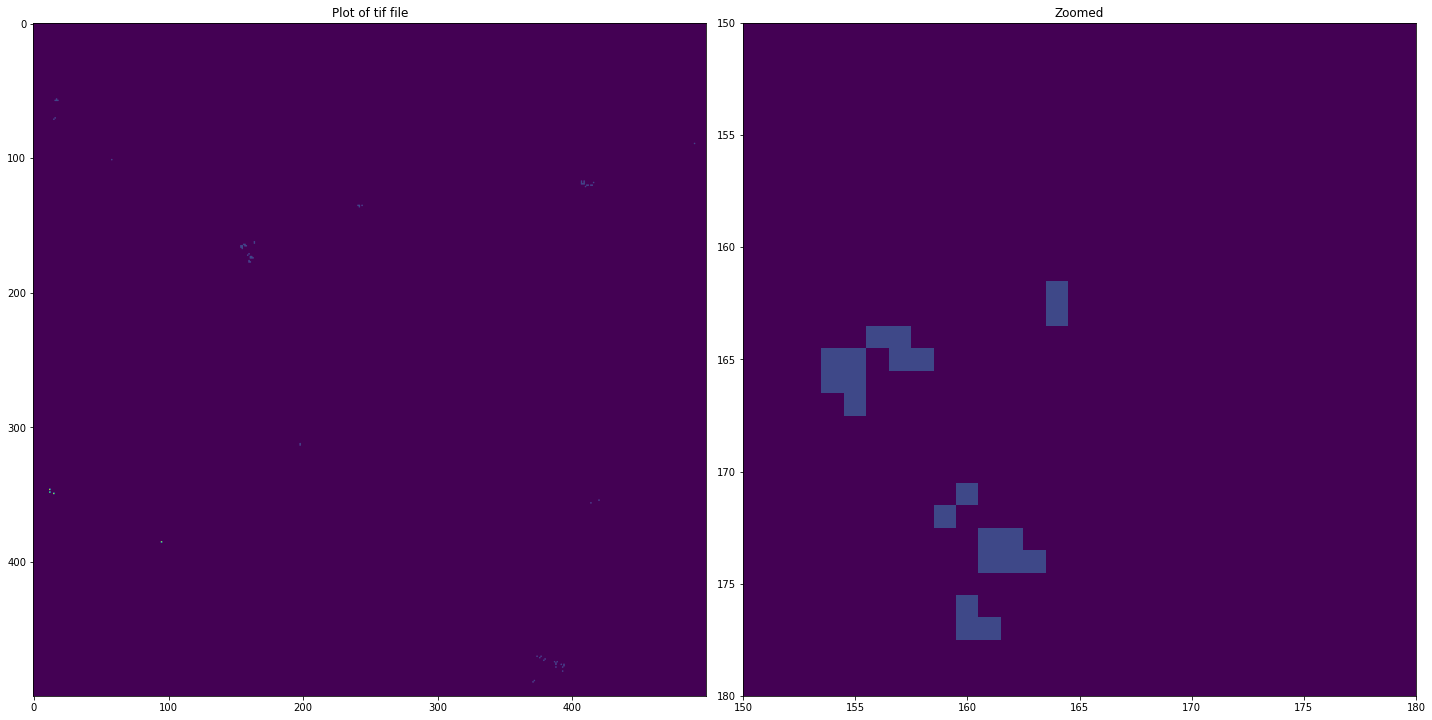

In [12]:
'''
data = np.nan_to_num(data)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
plt.imshow(data)
ax1.set_title('Plot of tif file')

ax2 = fig.add_subplot(122)
plt.imshow(data)
plt.xlim(150,180)
plt.ylim(180,150)
ax2.set_title('Zoomed')

fig.tight_layout()
'''

Now let's compare the two geodataframes of the csv and tif subsets. Once again, we show a zoomed in image on the right. Bearing in mind that the tif data has been converted from a pixel to a point, we note that the two datasets place their points on opposite corners of the pixel. This is not a concern as both points represent the same pixel.

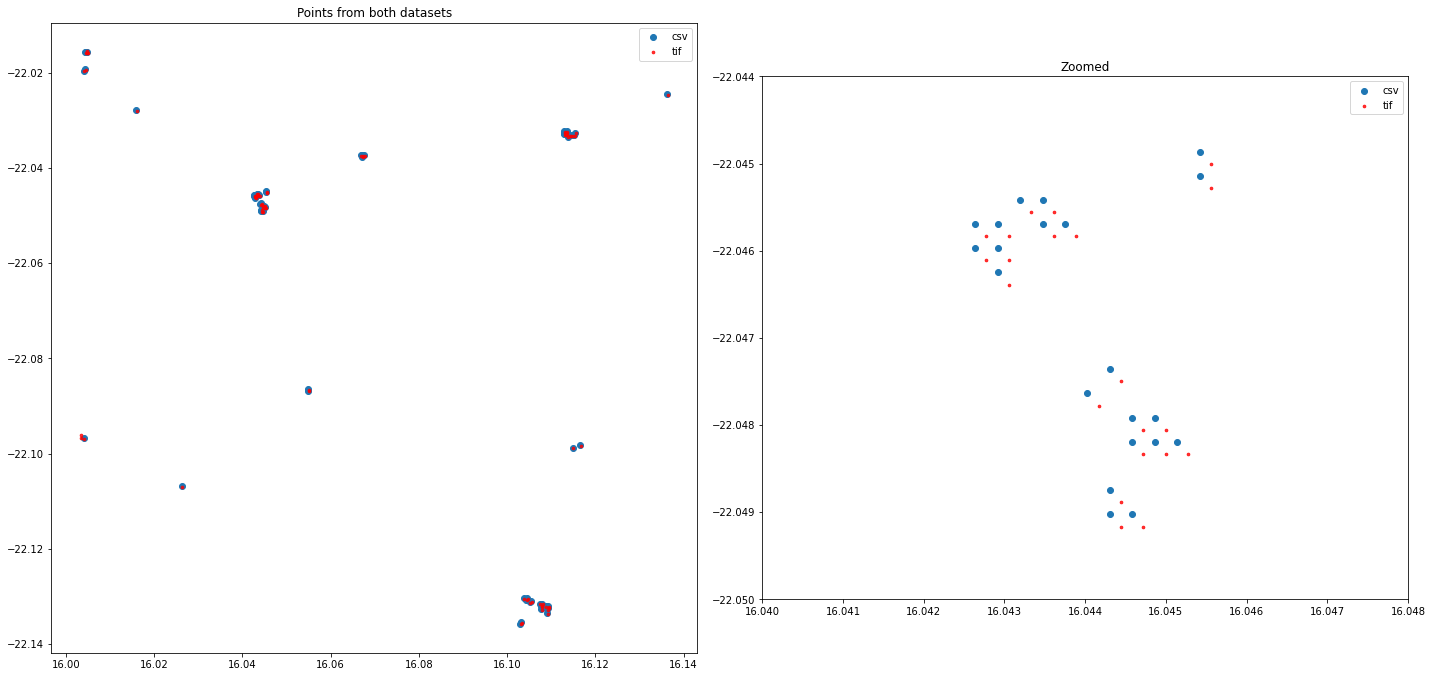

In [13]:
'''
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
gdf_box.plot(ax=ax1,label='csv')
data_gdf.plot(ax=ax1,color='red',alpha=0.8, markersize=7,label='tif')
ax1.set_title('Points from both datasets')
plt.legend()
ax2 = fig.add_subplot(122)
gdf_box.plot(ax=ax2,label='csv')
data_gdf.plot(ax=ax2,color='red',alpha=0.8, markersize=7,label='tif')
ax2.set_xlim(16.04,16.048)
ax2.set_ylim(-22.050,-22.044)
#ax2.set_ylim(-22.2044,-22.050)
ax2.set_title('Zoomed')
plt.legend()
fig.tight_layout()
'''

We have now determined that the csv and tif data refer to the same thing. As such, it is safe for us to continue our analysis using only the csv data.